In [1]:
# Predicting 30-Day Hospital Readmissions
This notebook analyzes diabetes patient encounters from 130 US hospitals (1999–2008).
- Goal: Predict 30-day readmission risk
- Models: Logistic Regression, XGBoost
- Evaluation: ROC-AUC, PR-AUC
- Interpretability: SHAP feature importance


SyntaxError: invalid character '–' (U+2013) (ipython-input-2186563517.py, line 2)

In [11]:
import pandas as pd

# load the main hospital data
df = pd.read_csv("diabetic_data.csv")

# Create target variable: 1 if readmitted within 30 days, 0 otherwise
df['target'] = (df['readmitted'] == '<30').astype(int)


In [12]:
# how many patients fall into each readmission bucket?
df['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [13]:
df.groupby('age')['target'].mean()

age
[0-10)      0.018634
[10-20)     0.057887
[20-30)     0.142426
[30-40)     0.112318
[40-50)     0.106040
[50-60)     0.096662
[60-70)     0.111284
[70-80)     0.117731
[80-90)     0.120835
[90-100)    0.110992
Name: target, dtype: float64

In [14]:
df.groupby('gender')['target'].mean()

gender
Female             0.112452
Male               0.110615
Unknown/Invalid    0.000000
Name: target, dtype: float64

In [15]:
df.groupby('race')['target'].mean()

race
?                  0.082710
AfricanAmerican    0.112181
Asian              0.101404
Caucasian          0.112906
Hispanic           0.104075
Other              0.096282
Name: target, dtype: float64

Matplotlib is building the font cache; this may take a moment.


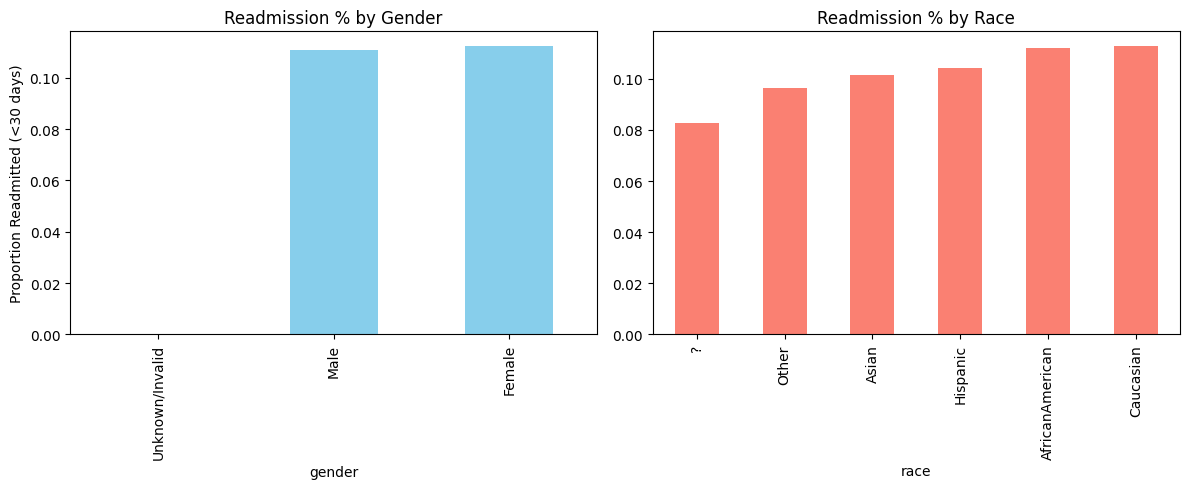

In [16]:
import matplotlib.pyplot as plt

# Gender readmission rates
gender_rates = df.groupby('gender')['target'].mean().sort_values()

# Race readmission rates
race_rates = df.groupby('race')['target'].mean().sort_values()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gender chart
gender_rates.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Readmission % by Gender")
axes[0].set_ylabel("Proportion Readmitted (<30 days)")

# Race chart
race_rates.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Readmission % by Race")

plt.tight_layout()
plt.show()

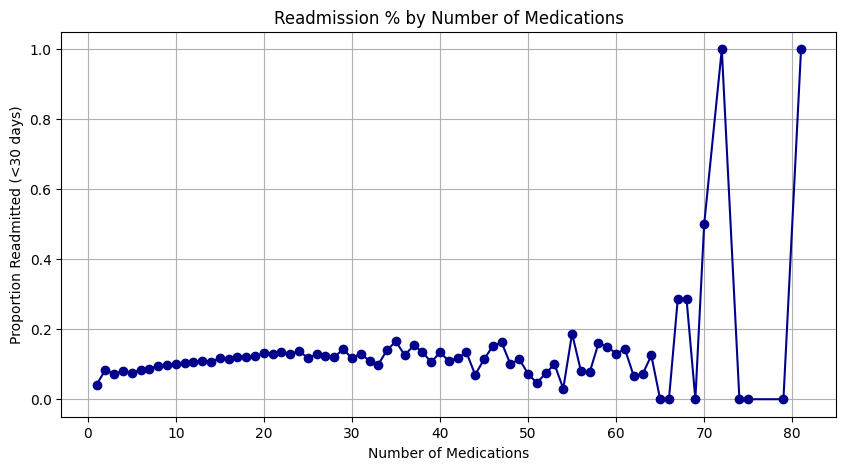

In [35]:
import matplotlib.pyplot as plt

# group by number of medications
med_readmit = df.groupby('num_medications')['target'].mean()

plt.figure(figsize=(10,5))
med_readmit.plot(kind='line', marker='o', color='darkblue')
plt.title("Readmission % by Number of Medications")
plt.xlabel("Number of Medications")
plt.ylabel("Proportion Readmitted (<30 days)")
plt.grid(True)
plt.show()

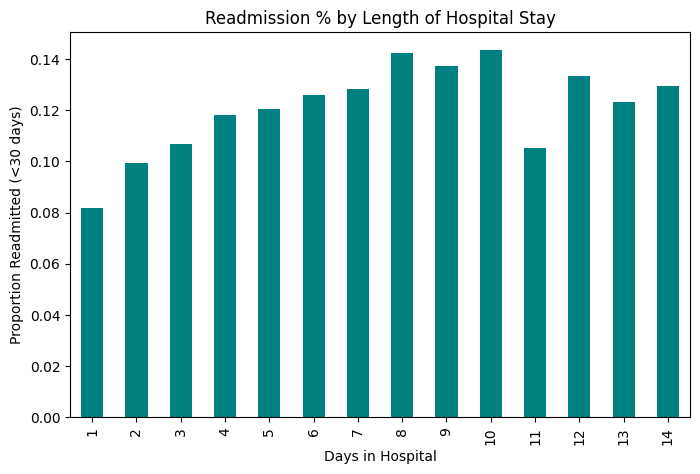

In [18]:
# group by length of stay
stay_readmit = df.groupby('time_in_hospital')['target'].mean()

plt.figure(figsize=(8,5))
stay_readmit.plot(kind='bar', color='teal')
plt.title("Readmission % by Length of Hospital Stay")
plt.xlabel("Days in Hospital")
plt.ylabel("Proportion Readmitted (<30 days)")
plt.show()

In [19]:
ids = pd.read_csv("IDS_mapping.csv")
ids.head(20)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


In [20]:
# Load the mapping file
ids = pd.read_csv("IDS_mapping.csv")

# Preview columns
print(ids.columns)

# Let's specifically filter rows related to "Admission type"
admission_map = ids[ids.iloc[:,1].str.contains("Admission", case=False, na=False)]

# Rename columns for clarity
admission_map = admission_map.rename(columns={ids.columns[0]: "Code", ids.columns[1]: "Description"})

print(admission_map)

Index(['admission_type_id', 'description'], dtype='object')
   Code                             Description
59   19  Readmission to Same Home Health Agency


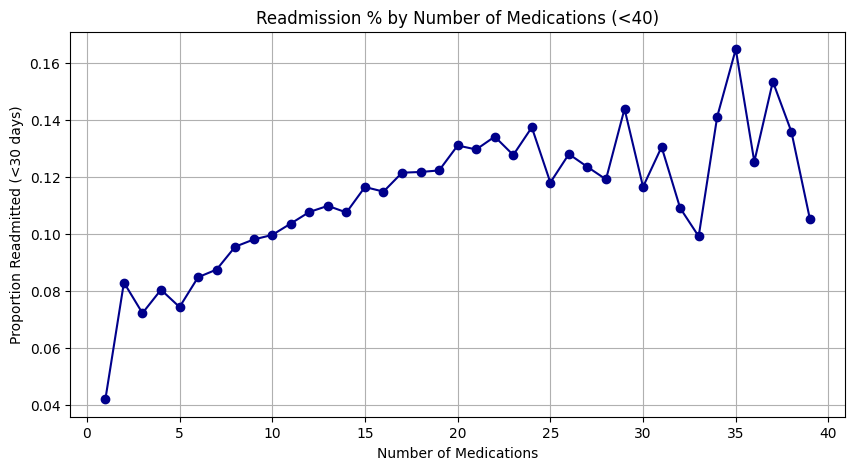

In [21]:
subset = df[df['num_medications'] < 40]
med_readmit = subset.groupby('num_medications')['target'].mean()

plt.figure(figsize=(10,5))
med_readmit.plot(kind='line', marker='o', color='darkblue')
plt.title("Readmission % by Number of Medications (<40)")
plt.xlabel("Number of Medications")
plt.ylabel("Proportion Readmitted (<30 days)")
plt.grid(True)
plt.show()

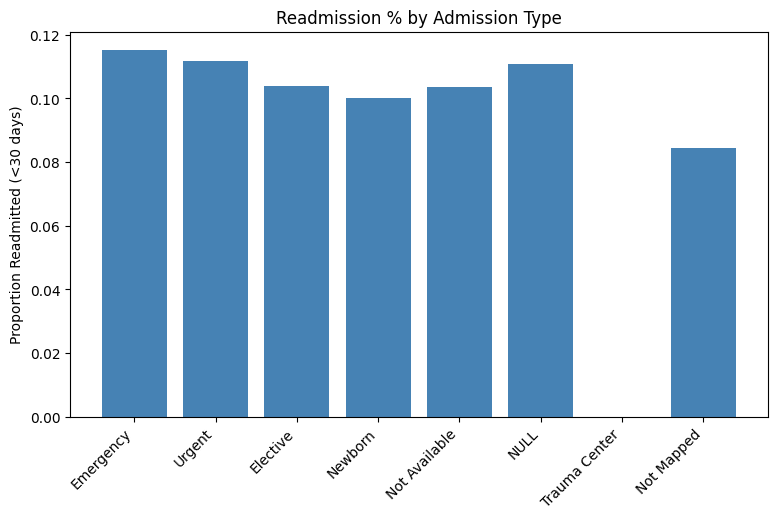

In [22]:
import matplotlib.pyplot as plt

# fallback mapping for admission_type_id
admission_labels = {
    1: "Emergency",
    2: "Urgent",
    3: "Elective",
    4: "Newborn",
    5: "Not Available",
    6: "NULL",
    7: "Trauma Center",
    8: "Not Mapped"
}

# calculate readmission % by admission_type_id
admission_readmit = df.groupby("admission_type_id")["target"].mean().reset_index()

# map numbers to labels
admission_readmit["Label"] = admission_readmit["admission_type_id"].map(admission_labels)

# plot with labels instead of numbers
plt.figure(figsize=(9,5))
plt.bar(admission_readmit["Label"], admission_readmit["target"], color="steelblue")
plt.title("Readmission % by Admission Type")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion Readmitted (<30 days)")
plt.show()

In [23]:
from sklearn.model_selection import GroupShuffleSplit

patients = df['patient_nbr'].unique()
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, valid_idx = next(gss.split(df, groups=df['patient_nbr']))

train = df.iloc[train_idx].copy()
valid = df.iloc[valid_idx].copy()

print(len(train), len(valid), train['target'].mean(), valid['target'].mean())

81613 20153 0.11280065675811451 0.10673348881059892


In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# numeric and categorical features
feature_cols_num = [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses'
]
feature_cols_cat = [
    'race','gender','age','admission_type_id','discharge_disposition_id',
    'admission_source_id','max_glu_serum','A1Cresult','change','diabetesMed'
]

X_train = train[feature_cols_num + feature_cols_cat]
y_train = train['target']
X_valid = valid[feature_cols_num + feature_cols_cat]
y_valid = valid['target']

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), feature_cols_cat),
    ('num', 'passthrough', feature_cols_num)
])


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

logit = Pipeline(steps=[
    ('prep', pre),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

logit.fit(X_train, y_train)
p_valid_logit = logit.predict_proba(X_valid)[:,1]

print("Logistic ROC-AUC:", roc_auc_score(y_valid, p_valid_logit))
print("Logistic PR-AUC :", average_precision_score(y_valid, p_valid_logit))

Logistic ROC-AUC: 0.6621700977385073
Logistic PR-AUC : 0.19926106951005934


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from xgboost import XGBClassifier

xgb = Pipeline(steps=[
    ('prep', pre),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric='logloss'
    ))
])

xgb.fit(X_train, y_train)
p_valid_xgb = xgb.predict_proba(X_valid)[:,1]

print("XGBoost ROC-AUC:", roc_auc_score(y_valid, p_valid_xgb))
print("XGBoost PR-AUC :", average_precision_score(y_valid, p_valid_xgb))

XGBoost ROC-AUC: 0.670232518717508
XGBoost PR-AUC : 0.2101189114090231


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

logit = Pipeline(steps=[
    ('prep', pre),  # preprocessing pipeline we defined earlier
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

logit.fit(X_train, y_train)
p_valid_logit = logit.predict_proba(X_valid)[:,1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_valid, p_valid_logit))
print("Logistic Regression PR-AUC :", average_precision_score(y_valid, p_valid_logit))

Logistic Regression ROC-AUC: 0.6621700977385073
Logistic Regression PR-AUC : 0.19926106951005934


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
from xgboost import XGBClassifier

xgb = Pipeline(steps=[
    ('prep', pre),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric='logloss'
    ))
])

xgb.fit(X_train, y_train)
p_valid_xgb = xgb.predict_proba(X_valid)[:,1]

print("XGBoost ROC-AUC:", roc_auc_score(y_valid, p_valid_xgb))
print("XGBoost PR-AUC :", average_precision_score(y_valid, p_valid_xgb))

XGBoost ROC-AUC: 0.670232518717508
XGBoost PR-AUC : 0.2101189114090231


In [29]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "ROC-AUC": [
        roc_auc_score(y_valid, p_valid_logit),
        roc_auc_score(y_valid, p_valid_xgb)
    ],
    "PR-AUC": [
        average_precision_score(y_valid, p_valid_logit),
        average_precision_score(y_valid, p_valid_xgb)
    ]
})
results

,Model,ROC-AUC,PR-AUC
0,Logistic Regression,0.662170,0.199261
1,XGBoost,0.670233,0.210119


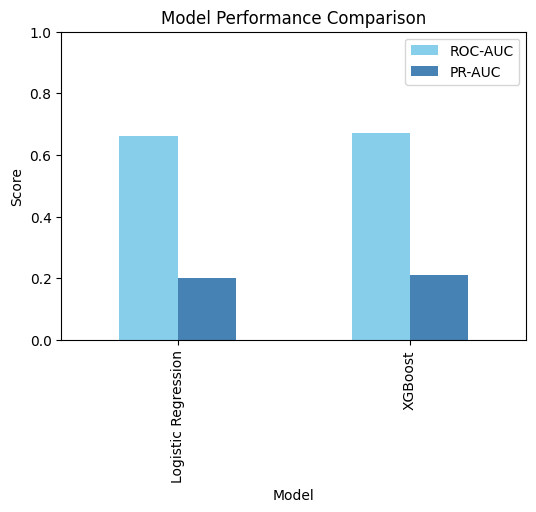

In [30]:
results.set_index("Model")[["ROC-AUC","PR-AUC"]].plot(
    kind="bar", figsize=(6,4), color=["skyblue","steelblue"]
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


In [31]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

# Collect results into a DataFrame
results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "ROC-AUC": [
        roc_auc_score(y_valid, p_valid_logit),
        roc_auc_score(y_valid, p_valid_xgb)
    ],
    "PR-AUC": [
        average_precision_score(y_valid, p_valid_logit),
        average_precision_score(y_valid, p_valid_xgb)
    ]
})

results.round(3)  # round to 3 decimal places for slide readability


,Model,ROC-AUC,PR-AUC
0,Logistic Regression,0.662,0.199
1,XGBoost,0.670,0.210


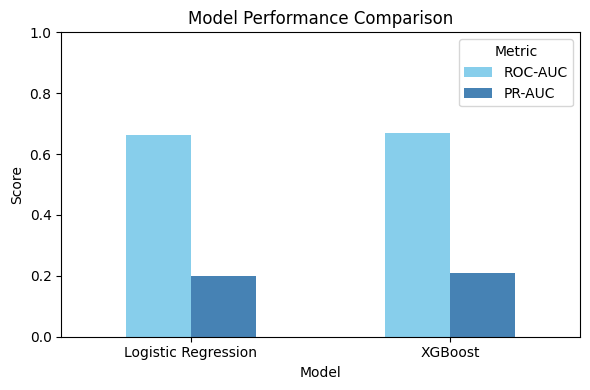

In [32]:
import matplotlib.pyplot as plt

# Plot bar chart
ax = results.set_index("Model")[["ROC-AUC","PR-AUC"]].plot(
    kind="bar", figsize=(6,4), color=["skyblue","steelblue"]
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [33]:
import numpy as np

# mean absolute SHAP value for each feature
importance_vals = np.abs(shap_values).mean(axis=0)

# put into DataFrame
importance_df = pd.DataFrame({
    "Feature": cleaned_feature_names,
    "Importance": importance_vals
}).sort_values("Importance", ascending=False).head(10)
importance_df

NameError: name 'shap_values' is not defined

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="dodgerblue")
plt.gca().invert_yaxis()  # highest at top
plt.xlabel("Average SHAP Impact on Prediction")
plt.title("Top 10 Drivers of Readmission (XGBoost)")
plt.tight_layout()
plt.show()

In [ ]:
df['target'] = (df['readmitted'] == '<30').astype(int)

# check how imbalanced it is
df['target'].value_counts(normalize=True)

In [ ]:
# readmission rates by age bucket
df.groupby('age')['target'].mean().sort_index()

In [ ]:
# readmission rates by gender
df.groupby('gender')['target'].mean()

In [ ]:
# readmission rates by race
df.groupby('race')['target'].mean()

In [ ]:
# how often does each admission type appear?
df['admission_type_id'].value_counts().head(10)

# readmission rates by admission type
df.groupby('admission_type_id')['target'].mean().head(10)

In [ ]:
# avg readmission rate by number of medications
df.groupby('num_medications')['target'].mean().head(20)

In [ ]:
# does longer stay = higher readmit chance?
df.groupby('time_in_hospital')['target'].mean()

In [ ]:
df.groupby('age')['readmitted'].apply(lambda x: (x == '<30').mean()).plot(
    kind='bar', title='Readmission rate by age group'
)
plt.ylabel("Proportion Readmitted (<30 days)")
plt.show()